<a href="https://colab.research.google.com/github/abosedealli/Stockprediction/blob/main/2..LSTM%20long%2060%20days%20and%2030days.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install tensorflow
!pip install pandas
import tensorflow as tf
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.callbacks import History 
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from keras.layers import *
from keras.callbacks import EarlyStopping 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
sns.set_style('whitegrid')
from datetime import datetime
xapp= pd.read_csv("/content/AAPL.dataset.csv")
xapp.shape
data = xapp.iloc[:int(0.8*len(xapp))]
print(data.shape)
data.info()
data

(8491, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8491 entries, 0 to 8490
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       8491 non-null   object 
 1   Open       8491 non-null   float64
 2   High       8491 non-null   float64
 3   Low        8491 non-null   float64
 4   Close      8491 non-null   float64
 5   Adj Close  8491 non-null   float64
 6   Volume     8491 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 464.5+ KB


,Date,Open,High,Low,Close,Adj Close,Volume
0,15/12/1980,0.122210,0.122210,0.121652,0.121652,0.094663,175884800
1,16/12/1980,0.113281,0.113281,0.112723,0.112723,0.087715,105728000
2,17/12/1980,0.115513,0.116071,0.115513,0.115513,0.089886,86441600
3,18/12/1980,0.118862,0.119420,0.118862,0.118862,0.092492,73449600
4,19/12/1980,0.126116,0.126674,0.126116,0.126116,0.098137,48630400
...,...,...,...,...,...,...,...
8486,7/08/2014,23.732500,23.987499,23.525000,23.620001,21.169622,186844000
8487,8/08/2014,23.565001,23.705000,23.320000,23.684999,21.227877,167460000
8488,11/08/2014,23.817499,24.020000,23.709999,23.997499,21.507961,146340000
8489,12/08/2014,24.010000,24.219999,23.902500,23.992500,21.503477,135180000


In [5]:
apple= data.assign(**{'average': lambda df: df.loc[:,['Open','High','Low','Close']].mean(axis=1), 
                    'EMA20': lambda df: df['average'].ewm(span=20, adjust=False).mean(), 
                    'EMA5': lambda df: df['average'].ewm(span=5, adjust=False).mean(), 
                    'dist_EMA20': lambda df: (df['average'] - df['EMA20'])/df['EMA20']*100, 
                    'dist_EMA5': lambda df: (df['average'] - df['EMA5'])/df['EMA5']*100})
apple.head()

,Date,Open,High,Low,Close,Adj Close,Volume,average,EMA20,EMA5,dist_EMA20,dist_EMA5
0,15/12/1980,0.122210,0.122210,0.121652,0.121652,0.094663,175884800,0.121931,0.121931,0.121931,0.000000,0.000000
1,16/12/1980,0.113281,0.113281,0.112723,0.112723,0.087715,105728000,0.113002,0.121081,0.118955,-6.672099,-5.004147
2,17/12/1980,0.115513,0.116071,0.115513,0.115513,0.089886,86441600,0.115652,0.120564,0.117854,-4.073496,-1.867943
3,18/12/1980,0.118862,0.119420,0.118862,0.118862,0.092492,73449600,0.119002,0.120415,0.118236,-1.173757,0.647040
4,19/12/1980,0.126116,0.126674,0.126116,0.126116,0.098137,48630400,0.126256,0.120971,0.120909,4.368292,4.421510


In [6]:
apple.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'average', 'EMA20', 'EMA5', 'dist_EMA20', 'dist_EMA5'],
      dtype='object')

In [7]:
apple

,Date,Open,High,Low,Close,Adj Close,Volume,average,EMA20,EMA5,dist_EMA20,dist_EMA5
0,15/12/1980,0.122210,0.122210,0.121652,0.121652,0.094663,175884800,0.121931,0.121931,0.121931,0.000000,0.000000
1,16/12/1980,0.113281,0.113281,0.112723,0.112723,0.087715,105728000,0.113002,0.121081,0.118955,-6.672099,-5.004147
2,17/12/1980,0.115513,0.116071,0.115513,0.115513,0.089886,86441600,0.115652,0.120564,0.117854,-4.073496,-1.867943
3,18/12/1980,0.118862,0.119420,0.118862,0.118862,0.092492,73449600,0.119002,0.120415,0.118236,-1.173757,0.647040
4,19/12/1980,0.126116,0.126674,0.126116,0.126116,0.098137,48630400,0.126256,0.120971,0.120909,4.368292,4.421510
...,...,...,...,...,...,...,...,...,...,...,...,...
8486,7/08/2014,23.732500,23.987499,23.525000,23.620001,21.169622,186844000,23.716250,23.892164,23.852275,-0.736282,-0.570283
8487,8/08/2014,23.565001,23.705000,23.320000,23.684999,21.227877,167460000,23.568750,23.861362,23.757767,-1.226302,-0.795601
8488,11/08/2014,23.817499,24.020000,23.709999,23.997499,21.507961,146340000,23.886249,23.863733,23.800594,0.094355,0.359885
8489,12/08/2014,24.010000,24.219999,23.902500,23.992500,21.503477,135180000,24.031250,23.879687,23.877480,0.634695,0.643997


In [8]:
apple.drop(["Date"],axis=1,inplace=True)

In [9]:
apple.head()

,Open,High,Low,Close,Adj Close,Volume,average,EMA20,EMA5,dist_EMA20,dist_EMA5
0,0.122210,0.122210,0.121652,0.121652,0.094663,175884800,0.121931,0.121931,0.121931,0.000000,0.000000
1,0.113281,0.113281,0.112723,0.112723,0.087715,105728000,0.113002,0.121081,0.118955,-6.672099,-5.004147
2,0.115513,0.116071,0.115513,0.115513,0.089886,86441600,0.115652,0.120564,0.117854,-4.073496,-1.867943
3,0.118862,0.119420,0.118862,0.118862,0.092492,73449600,0.119002,0.120415,0.118236,-1.173757,0.647040
4,0.126116,0.126674,0.126116,0.126116,0.098137,48630400,0.126256,0.120971,0.120909,4.368292,4.421510


In [10]:
testdf=  xapp.iloc[int(0.8*len(xapp)):]
testdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2123 entries, 8491 to 10613
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2123 non-null   object 
 1   Open       2123 non-null   float64
 2   High       2123 non-null   float64
 3   Low        2123 non-null   float64
 4   Close      2123 non-null   float64
 5   Adj Close  2123 non-null   float64
 6   Volume     2123 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 116.2+ KB


In [11]:
testdf.drop(["Date"],axis=1,inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
testdata=testdf.assign(**{'average': lambda df: df.loc[:,['Open','High','Low','Close']].mean(axis=1), 
                    'EMA20': lambda df: df['average'].ewm(span=20, adjust=False).mean(), 
                    'EMA5': lambda df: df['average'].ewm(span=5, adjust=False).mean(), 
                    'dist_EMA20': lambda df: (df['average'] - df['EMA20'])/df['EMA20']*100, 
                    'dist_EMA5': lambda df: (df['average'] - df['EMA5'])/df['EMA5']*100})
testdata.head()

,Open,High,Low,Close,Adj Close,Volume,average,EMA20,EMA5,dist_EMA20,dist_EMA5
8491,24.332500,24.392500,24.200001,24.375000,21.846294,112464000,24.325000,24.325000,24.325000,0.000000,0.000000
8492,24.475000,24.547501,24.215000,24.495001,21.953846,195804000,24.433126,24.335298,24.361042,0.401999,0.295897
8493,24.622499,24.842501,24.495001,24.790001,22.218248,190288000,24.687501,24.368841,24.469862,1.307651,0.889417
8494,24.852501,25.170000,24.830000,25.132500,22.525208,277596000,24.996250,24.428594,24.645324,2.323736,1.423904
8495,25.110001,25.272499,24.987499,25.142500,22.534174,210796000,25.128125,24.495216,24.806258,2.583805,1.297523


In [13]:
scalar = MinMaxScaler()
apple_scaled = scalar.fit_transform(apple)
print(apple_scaled.shape)
apple_scaled

(8491, 11)


array([[0.00289758, 0.00288663, 0.0029093 , ..., 0.00282064, 0.48475612,
        0.62170279],
       [0.00254094, 0.00253133, 0.00255122, ..., 0.0027009 , 0.42044282,
        0.54075796],
       [0.00263009, 0.00264235, 0.00266311, ..., 0.00265661, 0.44549112,
        0.59148779],
       ...,
       [0.94933091, 0.95380004, 0.94888239, ..., 0.95542645, 0.48566562,
        0.62752413],
       [0.95701975, 0.96175817, 0.95660234, ..., 0.95851958, 0.49087403,
        0.63211979],
       [0.95811815, 0.96533934, 0.96091345, ..., 0.96240042, 0.49523254,
        0.63472004]])

In [14]:
X_train = []
y_train = []


In [15]:
for i in range(60, apple.shape[0]):
    X_train.append(apple_scaled[i-60: i])
    y_train.append(apple_scaled[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((8431, 60, 11), (8431,))

In [16]:
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape, y_train.shape

((8431, 60, 11), (8431,))

In [17]:
regressor = Sequential()

regressor.add(LSTM(units = 70, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 11)))
regressor.add(Dropout(0.2))

regressor.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.3))

regressor.add(LSTM(units = 100, activation = 'relu', return_sequences = True))
regressor.add(Dropout(0.4))

regressor.add(LSTM(units = 140, activation = 'relu'))
regressor.add(Dropout(0.5))

regressor.add(Dense(units = 1))

In [18]:
regressor.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 70)            22960     
                                                                 
 dropout (Dropout)           (None, 60, 70)            0         
                                                                 
 lstm_1 (LSTM)               (None, 60, 80)            48320     
                                                                 
 dropout_1 (Dropout)         (None, 60, 80)            0         
                                                                 
 lstm_2 (LSTM)               (None, 60, 100)           72400     
                                                                 
 dropout_2 (Dropout)         (None, 60, 100)           0         
                                                                 
 lstm_3 (LSTM)               (None, 140)               1

In [19]:
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')
regressor.fit(X_train, y_train, epochs=5, batch_size = 64)

Epoch 1/5
132/132 [==============================] - 35s 231ms/step - loss: 0.0071
Epoch 2/5
132/132 [==============================] - 30s 231ms/step - loss: 0.0021
Epoch 3/5
132/132 [==============================] - 30s 230ms/step - loss: 0.0020
Epoch 4/5
132/132 [==============================] - 30s 231ms/step - loss: 0.0017
Epoch 5/5
132/132 [==============================] - 30s 231ms/step - loss: 0.0017


In [20]:
past_60 = apple.tail(60)

dt = past_60.append(testdata, ignore_index = True)
dt

,Open,High,Low,Close,Adj Close,Volume,average,EMA20,EMA5,dist_EMA20,dist_EMA5
0,21.589643,21.657143,21.454643,21.596786,19.260490,234836000,21.574554,20.838273,21.363548,3.533309,0.987689
1,21.565357,21.667856,21.502144,21.653929,19.311459,196859600,21.597321,20.910564,21.441473,3.284263,0.726857
2,21.664286,21.780357,21.575001,21.688213,19.342035,200760000,21.676964,20.983554,21.519970,3.304541,0.729529
3,21.687500,21.954643,21.659643,21.933214,19.560526,232209600,21.808750,21.062144,21.616230,3.544776,0.890627
4,21.995714,22.352142,21.986786,22.343929,19.926819,348866000,22.169643,21.167620,21.800701,4.733752,1.692339
...,...,...,...,...,...,...,...,...,...,...,...
2178,133.880005,134.259995,131.440002,133.410004,133.410004,71379600,133.247501,132.629022,131.210056,0.466323,1.552812
2179,132.029999,134.919998,131.660004,134.759995,134.759995,57758000,133.342499,132.696972,131.920870,0.486467,1.077637
2180,134.830002,137.289993,134.130005,135.940002,135.940002,63646600,135.547501,132.968451,133.129747,1.939595,1.816088
2181,136.820007,138.610001,135.029999,135.210007,135.210007,69672800,136.417504,133.296932,134.225666,2.341068,1.632950


In [21]:
inputs = scalar.fit_transform(dt)
print(inputs.shape)
inputs

(2183, 11)


array([[1.50784175e-04, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 6.68226981e-01, 5.82187370e-01],
       [0.00000000e+00, 6.64236737e-05, 3.01277354e-04, ...,
        4.92563591e-04, 6.59751924e-01, 5.65400833e-01],
       [6.14219205e-04, 7.63962152e-04, 7.63376344e-04, ...,
        9.88747820e-04, 6.60441980e-01, 5.65572798e-01],
       ...,
       [7.03224739e-01, 7.16956847e-01, 7.14648847e-01, ...,
        7.06479314e-01, 6.13992640e-01, 6.35501150e-01],
       [7.15580057e-01, 7.25141275e-01, 7.20357102e-01, ...,
        7.13406667e-01, 6.27654816e-01, 6.23714807e-01],
       [6.98568223e-01, 7.10508592e-01, 7.12365523e-01, ...,
        7.14706351e-01, 5.83648421e-01, 5.38309036e-01]])

In [22]:
X_test = []
y_test = []

for i in range(60, inputs.shape[0]):
    X_test.append(inputs[i-60:i])
    y_test.append(inputs[i, 0])
    
X_test, y_test = np.array(X_test), np.array(y_test).reshape(-1,1)
X_test.shape, y_test.shape

((2123, 60, 11), (2123, 1))

In [23]:
y_pred = regressor.predict(X_test)

67/67 [==============================] - 3s 41ms/step


In [24]:
y_pred.shape

(2123, 1)

In [25]:
node = pd.isnull(y_pred).any(1).nonzero()[0]

In [26]:
y_pred = np.delete(y_pred,node)
y_test = np.delete(y_test,node)

In [27]:
ans = pd.DataFrame()
ans['y_pred'] = y_pred
ans['y_test'] = y_test    

In [28]:
ans = ans.dropna()
scale = 1/scalar.scale_[0]

In [29]:
y_pred = y_pred*scale
y_test = y_test*scale

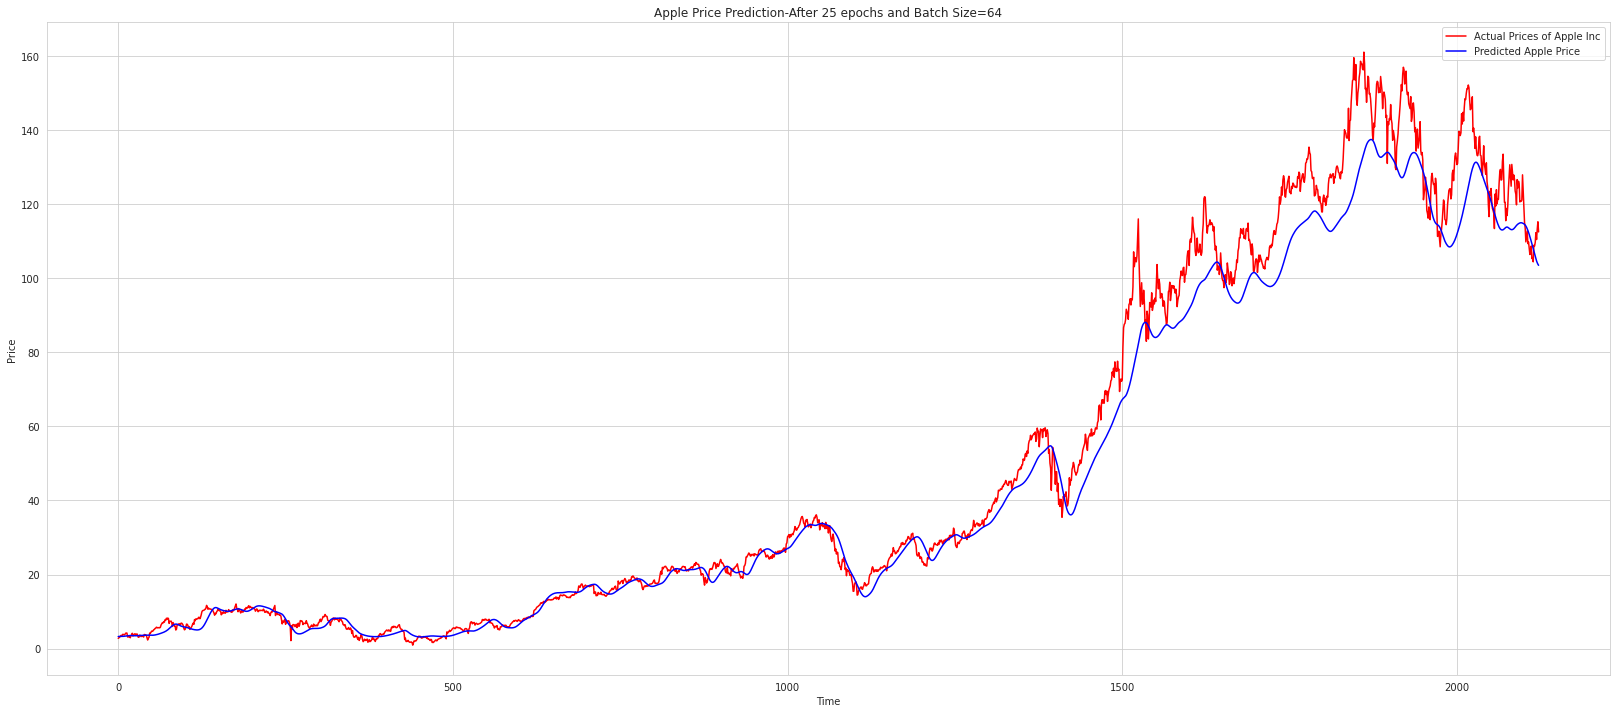

In [30]:
# Visualising the results
plt.figure(figsize=(28,12))
plt.plot(y_test, color = 'red', label = 'Actual Prices of Apple Inc')
plt.plot(y_pred, color = 'blue', label = 'Predicted Apple Price')
plt.title('Apple Price Prediction-After 25 epochs and Batch Size=64')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

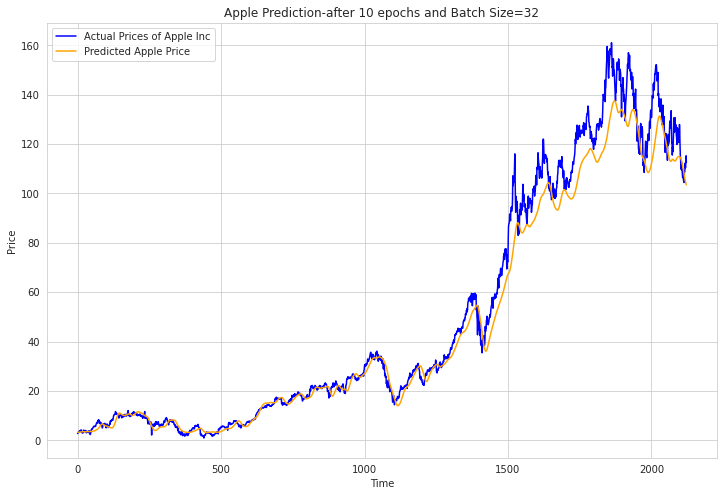

In [31]:
# Visualising time.........Visualizing various results at different epoch and batch size
plt.figure(figsize=(12,8))
plt.plot(y_test, color = 'blue', label = 'Actual Prices of Apple Inc')
plt.plot(y_pred, color = 'orange', label = 'Predicted Apple Price')
plt.title('Apple Prediction-after 10 epochs and Batch Size=32')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

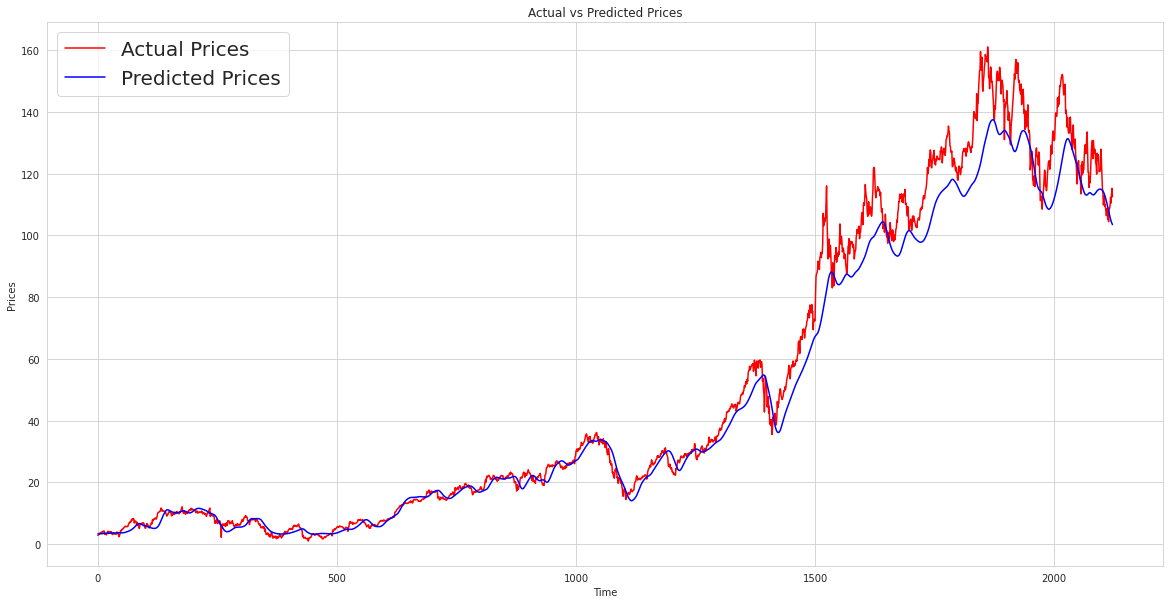

In [32]:
plt.figure(figsize=(20,10))
plt.plot(y_test,'red',label='Actual Prices')
plt.plot(y_pred,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Actual vs Predicted Prices')
plt.legend(loc='best', fontsize=20)

In [56]:
 print(mean_squared_error(ans.y_test, ans.y_pred, squared = False))      #MSE

0.04976009397087936


In [57]:
print(mean_squared_error(ans.y_test, ans.y_pred, squared = True))         #RMSE

0.0024760669519907448


In [35]:
from sklearn.metrics import mean_absolute_error
mae= np.mean(np.abs(ans.y_pred - y_test))
from keras.metrics.metrics import mean_absolute_percentage_error
mape = (np.mean(np.abs(ans.y_pred - y_test) /y_test))

print("MAE:", mae)
print("MAPE:", mape)

MAE: 49.35154680383715
MAPE: 0.9940126895063909


In [36]:
apple

,Open,High,Low,Close,Adj Close,Volume,average,EMA20,EMA5,dist_EMA20,dist_EMA5
0,0.122210,0.122210,0.121652,0.121652,0.094663,175884800,0.121931,0.121931,0.121931,0.000000,0.000000
1,0.113281,0.113281,0.112723,0.112723,0.087715,105728000,0.113002,0.121081,0.118955,-6.672099,-5.004147
2,0.115513,0.116071,0.115513,0.115513,0.089886,86441600,0.115652,0.120564,0.117854,-4.073496,-1.867943
3,0.118862,0.119420,0.118862,0.118862,0.092492,73449600,0.119002,0.120415,0.118236,-1.173757,0.647040
4,0.126116,0.126674,0.126116,0.126116,0.098137,48630400,0.126256,0.120971,0.120909,4.368292,4.421510
...,...,...,...,...,...,...,...,...,...,...,...
8486,23.732500,23.987499,23.525000,23.620001,21.169622,186844000,23.716250,23.892164,23.852275,-0.736282,-0.570283
8487,23.565001,23.705000,23.320000,23.684999,21.227877,167460000,23.568750,23.861362,23.757767,-1.226302,-0.795601
8488,23.817499,24.020000,23.709999,23.997499,21.507961,146340000,23.886249,23.863733,23.800594,0.094355,0.359885
8489,24.010000,24.219999,23.902500,23.992500,21.503477,135180000,24.031250,23.879687,23.877480,0.634695,0.643997


In [37]:
apple_AdjClose= apple.iloc[:,3].values.reshape(-1,1)
apple_AdjClose

array([[ 0.121652],
       [ 0.112723],
       [ 0.115513],
       ...,
       [23.997499],
       [23.9925  ],
       [24.309999]])

In [39]:
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
apple_AdjClose_scaled= ss.fit_transform(apple_AdjClose)

In [40]:
xtrain=[]
ytrain=[]
for i in range(30,len(apple_AdjClose_scaled)):
    xtrain.append(apple_AdjClose_scaled[i-30:i,0])
    ytrain.append(apple_AdjClose_scaled[i,0])

xtrain, ytrain = np.array(xtrain), np.array(ytrain)

xtrain= np.reshape(xtrain,(xtrain.shape[0],xtrain.shape[1],1))
print(xtrain.shape)
print(ytrain.shape)

(8461, 30, 1)
(8461,)


In [41]:
regression= Sequential()

#First Input layer and LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,return_sequences=True,kernel_initializer='glorot_uniform',input_shape=(xtrain.shape[1],1)))
regression.add(Dropout(0.2))

# Where:
# return_sequences: Boolean. Whether to return the last output in the output sequence, or the full sequence.

# Second LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Third LSTM layer with 0.2% dropout
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform',return_sequences=True))
regression.add(Dropout(0.2))

#Fourth LSTM layer with 0.2% dropout, we wont use return sequence true in last layers as we dont want to previous output
regression.add(LSTM(units=50,kernel_initializer='glorot_uniform'))
regression.add(Dropout(0.2))
#Output layer , we wont pass any activation as its continous value model
regression.add(Dense(units=1))

#Compiling the network
regression.compile(optimizer='adam',loss='mean_squared_error')


#fitting the network
regression.fit(xtrain,ytrain,batch_size=30,epochs=50)

Epoch 1/50
283/283 [==============================] - 17s 42ms/step - loss: 0.0022
Epoch 2/50
283/283 [==============================] - 13s 45ms/step - loss: 0.0010
Epoch 3/50
283/283 [==============================] - 12s 42ms/step - loss: 9.9370e-04
Epoch 4/50
283/283 [==============================] - 12s 41ms/step - loss: 8.4037e-04
Epoch 5/50
283/283 [==============================] - 12s 41ms/step - loss: 7.5468e-04
Epoch 6/50
283/283 [==============================] - 12s 42ms/step - loss: 7.7687e-04
Epoch 7/50
283/283 [==============================] - 12s 42ms/step - loss: 7.2604e-04
Epoch 8/50
283/283 [==============================] - 12s 42ms/step - loss: 6.5669e-04
Epoch 9/50
283/283 [==============================] - 12s 43ms/step - loss: 6.2144e-04
Epoch 10/50
283/283 [==============================] - 12s 43ms/step - loss: 5.4657e-04
Epoch 11/50
283/283 [==============================] - 12s 43ms/step - loss: 6.9614e-04
Epoch 12/50
283/283 [============================

In [42]:
testdata_AdjClose= testdata.iloc[:,3].values.reshape(-1,1) #taking  price

In [43]:
from sklearn.preprocessing import MinMaxScaler
ss= MinMaxScaler(feature_range=(0,1))
testdata_AdjClose= ss.fit_transform(testdata_AdjClose)

In [ ]:
testdata_AdjClose.shape

In [45]:
xtest=[]
ytest=[]
for i in range(30,len(testdata_AdjClose)):
    xtest.append(testdata_AdjClose[i-30:i,0])
    ytest.append(testdata_AdjClose[i,0])

xtest, ytest = np.array(xtest), np.array(ytest)

xtest= np.reshape(xtest,(xtest.shape[0],xtest.shape[1],1))
print(xtest.shape)
print(ytest.shape)

(2093, 30, 1)
(2093,)


In [46]:
predicted_value= regression.predict(xtest)

66/66 [==============================] - 2s 12ms/step


In [47]:
predicted_value.shape

(2093, 1)

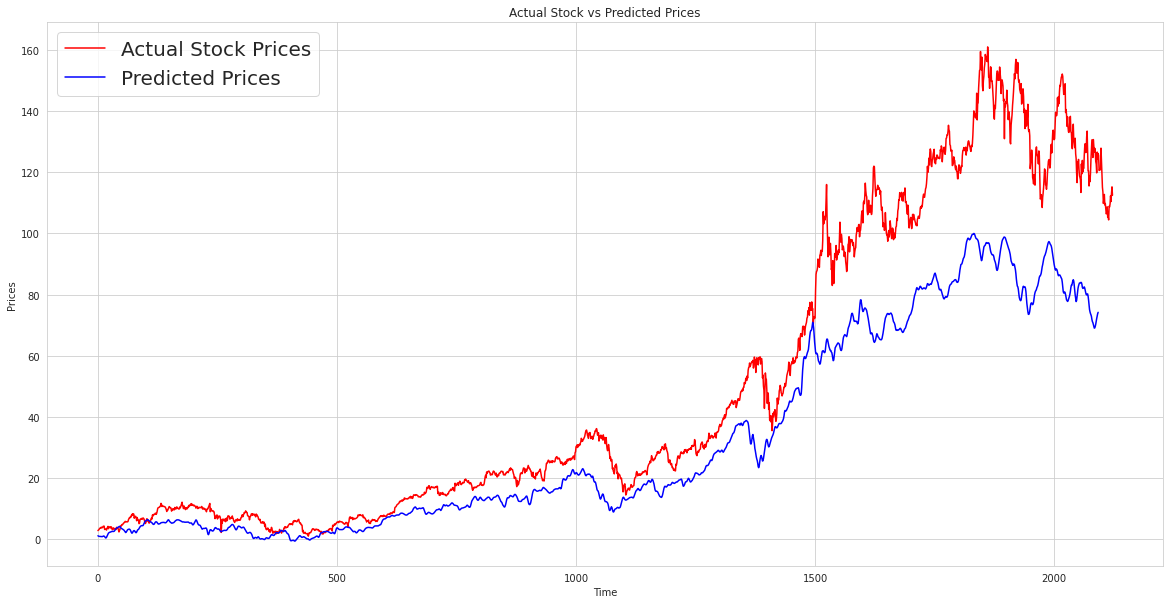

In [55]:
plt.figure(figsize=(20,10))
plt.plot(y_test,'red',label='Actual Stock Prices')
plt.plot(predicted_value*100,'blue',label='Predicted Prices')
plt.xlabel('Time')
plt.ylabel('Prices')
plt.title('Actual Stock vs Predicted Prices')
plt.legend(loc='best', fontsize=20)

MSE=

In [49]:
print(mean_squared_error(ytest, predicted_value, squared = False))

0.026697380266655017


RMSE

In [50]:
print(mean_squared_error(ytest, predicted_value, squared = True))

0.0007127501131023807


MAE and MAPE

In [58]:
from sklearn.metrics import mean_absolute_error
mae= np.mean(np.abs(predicted_value - ytest))
from keras.metrics.metrics import mean_absolute_percentage_error
mape = (np.mean(np.abs(predicted_value - ytest) /ytest))

print("MAE:", mae)
print("MAPE:", mape)

MAE: 0.33840326649918934
MAPE: inf


<ipython-input-58-8bdb9dcf6672>:4: RuntimeWarning: divide by zero encountered in true_divide
  mape = (np.mean(np.abs(predicted_value - ytest) /ytest))
